In [1]:
import yaml
import sys
from pprint import pprint
import argparse
import os, glob, re
import numpy as np
import pandas as pd
import networkx as nx
# plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [2]:
#metric = 'frequency'
#metric_ = metric + ' (avg)'

#metric = 'frequency'
#metric_ = metric + ' (sum)'

#metric = 'access_size'
#metric_ = metric + ' (avg)'

#metric = 'access_size'
#metric_ = metric + ' (sum)'

metric = 'weighted_access_size'
metric_ = metric + ' (sum)'

filtered_file_ext = 'h5'


In [3]:
def printmd(string):
    display(Markdown(string))

In [4]:
def convert2Dict(dlist, id_name):
    return {x[id_name]: x for x in dlist}

def import_yaml(fname):
    with open(fname) as f:
        return yaml.safe_load(f)

In [5]:
class Conversion(object):

    data = None
    job_dependency = None
    tasks = None
    cmds = None
    files = None

    def user_input(self):
        parser = argparse.ArgumentParser('Pegasus DAX Parser')
        parser.add_argument('-w', '--workflow_yml')
        parser.add_argument('-r', '--replica_yml')
        parser.add_argument('-t', '--transformation_yml')
        parser.add_argument('-p', '--radical_pst_yml', help='output yaml filename')
        parser.add_argument('-o', '--output', help='shell script output')
        args = parser.parse_args()
        self.args = args
        return args


    def import_dax(self):

        data = None
        jdep = None
        tasks = None
        files = None
        cmds = None

        if self.args.workflow_yml:
            data = import_yaml(self.args.workflow_yml)
            jdep = data['jobDependencies']

            if 'transformationCatalog' in data:
                tasks = convert2Dict(data['transformationCatalog']['transformations'], 'name')
            if 'jobs' in data:
                cmds = convert2Dict(data['jobs'], 'id')
            if 'replicaCatalog' in data:
                files = convert2Dict(data['replicaCatalog']['replicas'], 'lfn')
        if self.args.replica_yml:
            repl = import_yaml(self.args.replica_yml)
            files = convert2Dict(repl['replicas'], 'lfn')
        if self.args.transformation_yml:
            trans = import_yaml(self.args.transformation_yml)
            tasks = convert2Dict(trans['transformations'], 'name')

        self.data = data
        self.job_dependency = jdep
        self.tasks = tasks
        self.cmds = cmds
        self.files = files


    def get_jdep(self):
        dict_dep = {}

        for i in self.job_dependency:
            dict_dep[i['id']] = i['children']

        ordered = {}
        for pjob_id, child_ids in dict_dep.items():
            if pjob_id not in ordered:
               ordered[pjob_id] = 1
            for cjob_id in child_ids:
                if cjob_id not in ordered:
                   ordered[cjob_id] = ordered[pjob_id] + 1
                else:
                   ordered[cjob_id] = max(ordered[pjob_id] + 1, ordered[cjob_id])
        self.ordered = ordered
        self.ordered_by_val = {k: v for k, v in sorted(ordered.items(), key=lambda item: item[1])}


    def get_cmd(self, cid):
        cname = self.cmds[cid]['name']
        #     {'name': 'mConvert', 'sites': [{'name': 'local', 'pfn':
        #     '/files0/oddite/leeh736/Montage/bin/mConvert', 'type': 'stageable'}],
        #     'profiles': {'condor': {'request_memory': '1 GB'}, 'env': {'PATH':
        #     '/usr/bin:/bin:.'}}}
        t_path = self.tasks[cname]['sites'][0]['pfn']
        return t_path


    def get_arguments(self, cid):
        return self.cmds[cid]['arguments']


    def get_data(self, cid):

        inputs = []
        outputs = []
        pre_exec = []

        flist = self.cmds[cid]['uses']
        # uses: 
        # - lfn: pposs2ukstu_blue_001_002_area.fits
        #   type: output
        #   stageOut: false
        #   registerReplica: true
        # - lfn: poss2ukstu_blue_001_002.fits
        #   type: input
        for v in flist:
            fname = v['lfn']
            ftype = v['type']
            # - lfn: region-oversized.hdr
            #   pfns:
            #   - site: local
            #     pfn: file:///files0/oddite/leeh736/montage-workflow-v3/data/region-oversized.hdr
            if fname in self.files:
                fobj = self.files[fname]
                flocation = fobj['pfns'][0]['site']
                fpath = fobj['pfns'][0]['pfn']
                if flocation == "local":
                    # local copy to cwd
                    if fpath[:7] == "file://":
                        sp = 7
                    else:
                        sp = 0
                    cmd = ["/bin/cp", fpath[sp:], "./"] # '7:', removing the `file://` protocol by indexing counts
                else: # ipac
                    # remote download to cwd
                    cmd = ["/bin/curl", "-o", fname, f"'{fpath}'"]
                pre_exec.append(cmd)
            if ftype == "output":
                outputs.append(fname)
                if v['registerReplica']:
                    self.files[fname] = {'pfns': [{'site': 'local', 'pfn': f'file://${cid}/{fname}'}]}
            else:
                inputs.append(fname)
        return {'inputs': inputs,
                'outputs': outputs,
                'pre_exec': pre_exec}


    def retrieve_cmd_info(self, cid):
        t_exec = self.get_cmd(cid)
        args = self.get_arguments(cid)
        tmp = self.get_data(cid)
        return {'exec': t_exec, 'args': args, 'inputs': tmp['inputs'], 'outputs':
                tmp['outputs'], 'pre_exec': tmp['pre_exec']}


    def update_id_map_to_pst(self, t_info, m_info):
        pre_exec = t_info['pre_exec']
        for cmd in pre_exec:
            idx = 0
            for element in cmd:
                if element[0] == "$":
                    idname, rest = element.split("/",1)
                    tmp = m_info[idname[1:]]
                    cmd[idx] = "%s/%s" % (tmp, rest)
                idx += 1

    def convert_to_pst(self):
        pst = {}
        t_cnt = 0
        id_map_to_pst = {}
        for k, v in self.ordered_by_val.items():
            t_info = self.retrieve_cmd_info(k)
            s_name = 'stage_%s' % v
            t_name = 'task_%s' % t_cnt
            id_map_to_pst[k] = f'$pipeline_0_{s_name}_{t_name}'
            self.update_id_map_to_pst(t_info, id_map_to_pst)
            task = { t_name : t_info }
            if s_name in pst:
                pst[s_name].append(task)
            else:
                pst[s_name] = [task]
            t_cnt += 1

        pprint(pst, indent=4)
        self.pst = pst

    def save_pst_yml(self):
        outfname = self.args.radical_pst_yml
        if outfname:
            with open(outfname, 'w') as outfile:
                yaml.dump(self.pst, outfile, default_flow_style=False)

    def save_shell_script(self):
        outfname = self.args.output
        if outfname:
            with open(outfname, 'w') as outfile:
                lines = []
                for k, v in self.ordered_by_val.items():
                    t_info = self.retrieve_cmd_info(k)
                    for l in t_info['pre_exec']:
                        outfile.write(" ".join(l) + "\n")
                    line = "%s %s " % (t_info['exec'], " ".join(t_info['args']))
                    outfile.write(f"{line}\n")


In [6]:
class args():
    workflow_yml = None
    replica_yml = None
    transformation_yml = None

args = args()
args.workflow_yml = 'ddmd_workflow_360k.yml'

In [7]:
obj = Conversion()
obj.args = args
obj.import_dax()
obj.get_jdep()

In [8]:
# loading tazer stat files into pandas dataframe
def stat_to_df(fname):

    df = pd.read_csv(fname, sep=' ', names=['block_idx', 'frequency', 'access_size'], skiprows=1)
    return df

def read_tazer_stats(dpath):

    agg_sum = {'frequency':'sum', 'access_size':'sum', 'weighted_access_size': 'sum'}
    agg_avg = {'frequency':'mean', 'access_size':'mean', 'weighted_access_size': 'mean'}
    agg_sum_rename = {'frequency': 'frequency (sum)', 
                      'access_size': 'access_size (sum)', 
                      'weighted_access_size': 'weighted_access_size (sum)'}
    agg_avg_rename = {'frequency': 'frequency (avg)', 
                      'access_size': 'access_size (avg)',
                      'weighted_access_size': 'weighted_access_size (avg)'}

    df_all = {}

    for fpath in glob.glob(dpath + "/*/*_stat"):

        # ignore trace stats but for r/w stat
        if fpath[-10:] == "trace_stat":
            continue
        df = stat_to_df(fpath)
        if df.empty is True:
            continue
            
        df['weighted_access_size'] = df['frequency'] * df['access_size']
        task_name = os.path.basename(os.path.dirname(fpath))
        stat_filename = os.path.basename(fpath)
        series = df.agg(agg_sum)
        df_sum = pd.DataFrame(series).transpose().rename(columns=agg_sum_rename)
        series = df.agg(agg_avg)
        df_avg = pd.DataFrame(series).transpose().rename(columns=agg_avg_rename)
        df = pd.concat([df_sum, df_avg], axis=1)
        if task_name in df_all:
            if stat_filename in df_all[task_name]:
                print(fname, "==duplicate==")
            df_all[task_name][stat_filename] = df
        else:
            df_all[task_name] = {stat_filename: df}
            
    return df_all

In [9]:
# custom func for ddmd (non-pegasus)
def parse_strace_stdout(strace_log_fname, filter_fname_ext):

    fd_dict = {}
    stat_dict = {}

    with open(strace_log_fname) as f:
        lines = f.readlines()
    for line in lines:
        fmode = ""
        fperm = ""
        fm = ""
        func_name = line.split("(")[0]
        if func_name == "open":
            func, ret = line.rsplit("=", 1)
            _, fname, __ = func.split('"')
            tmp = __.split(",")
            if len(tmp) > 2:
                fmode, fperm = tmp[1], tmp[2]
            else:
                fmode = tmp[1]
            fmode = fmode.strip()
            if "O_RDONLY" in fmode:
                fm = "r"
            else:
                fm = "w"
            ret = ret.strip()
            try:
                if int(ret) < 0:
                    continue
            except ValueError: # -1 ENOENT (No such file or directory)
                continue
            fname_ext = os.path.basename(fname).split(".")[-1]
            #print(line, fname_ext)
            if fname_ext != filter_fname_ext:
                continue
            if ret not in fd_dict:
                fd_dict[ret] = {'fname':fname, 'func_stat': func_name, 
                                'fmode': fm, 'fmode_ori': fmode, 'fperm': fperm,
                               'stat_w':[], 'stat_r':[]}
            else:
                print("fd is duplicate!:", ret, fname)
            #print(fname, ret, fext, line)
        elif func_name == "read" or func_name == "pread64":
            func, ret = line.rsplit('=', 1)
            tmp = func.split(",")
            fd = tmp[0]
            if len(tmp) >= 3:
                msg, size, _ = tmp[1], tmp[2], tmp[3:]
            fd = fd.split("(")[1]
            size = size.strip()[:-1] # removing ")" by [:-1]
            ret = ret.strip()
            #print(fd, size, ret, line)
            if fd not in fd_dict:
                #print ("%s is not in the list" % fd)
                continue
            #print(line)
            fd_dict[fd]['stat_r'].append(ret)
            #print(        fd_dict[fd]['stat'])
        elif func_name == "write" or func_name == "pwrite64":
            func, ret = line.rsplit('=', 1)
            tmp = func.split(",")
            fd = tmp[0]
            if len(tmp) >= 3:
                msg, size, _ = tmp[1], tmp[2], tmp[3:]
            fd = fd.split("(")[1]
            size = size.strip()[:-1] # removing ")" by [:-1]
            ret = ret.strip()
            #print(fd, size, ret, line)
            if fd not in fd_dict:
                #print ("%s is not in the list" % fd)
                continue
            #print(line)
            fd_dict[fd]['stat_w'].append(ret)
            #print(        fd_dict[fd]['stat'])        
        elif func_name == "close":
            fd = line.split("(")[1].split(")")[0]
            #print(fd, line)
            if fd not in fd_dict:
                #print (fd, " is not in the list")
                continue
            fname = fd_dict[fd]['fname']
            if fname in stat_dict:
                #print ("already exist!", fname)
                stat_dict[fname]['stat_w'] += fd_dict[fd]['stat_w']
                stat_dict[fname]['stat_r'] += fd_dict[fd]['stat_r']            
            else:
                stat_dict[fname] = fd_dict[fd]
            #print("deleting:", fd, fd_dict[fd])
            del(fd_dict[fd])
            #break
    return stat_dict

In [10]:
ddmd_stat_train = parse_strace_stdout('tazer_stat/ddmd/strace_train_no_tazer_on_cpu_node_local.1st.log', filter_fname_ext="h5")

In [11]:
ddmd_stat_agent = parse_strace_stdout('tazer_stat/ddmd/strace_agent_no_tazer.rand.log', filter_fname_ext="h5")

In [12]:
ddmd_stat_agg = parse_strace_stdout('tazer_stat/ddmd/strace_agg_output.rand.log', filter_fname_ext="h5")

In [13]:
def build_df_from_strace(stat_dict, task_name):

    df_all = {task_name:{}}
    for k, v in stat_dict.items():
        #print(k,v)
        for ftype in ["r", "w"]:
            stat_filename = os.path.basename(k) + "_%s_stat" % ftype
            df = pd.DataFrame(stat_dict[k][f'stat_{ftype}'], columns=['access_size'])
            df = df.astype({'access_size':'int'})
            df['frequency'] = 1
            df['block_idx'] = df.index

            agg_sum = {'frequency':'sum', 'access_size':'sum', 'weighted_access_size': 'sum'}
            agg_avg = {'frequency':'mean', 'access_size':'mean', 'weighted_access_size': 'mean'}
            agg_sum_rename = {'frequency': 'frequency (sum)', 
                              'access_size': 'access_size (sum)', 
                              'weighted_access_size': 'weighted_access_size (sum)'}
            agg_avg_rename = {'frequency': 'frequency (avg)', 
                              'access_size': 'access_size (avg)',
                              'weighted_access_size': 'weighted_access_size (avg)'}

            if df.empty is True:
                continue
            #print(df.dtypes)

            df['weighted_access_size'] = df['frequency'] * df['access_size']
            series = df.agg(agg_sum)
            df_sum = pd.DataFrame(series).transpose().rename(columns=agg_sum_rename)
            series = df.agg(agg_avg)
            df_avg = pd.DataFrame(series).transpose().rename(columns=agg_avg_rename)
            df = pd.concat([df_sum, df_avg], axis=1)
            
            if stat_filename in df_all[task_name]:
                df_prev = df_all[task_name][stat_filename]
                #tmp = pd.concat([df, df_prev],axis=0, ignore_index=True)
                df = pd.concat([df, df_prev],axis=0).groupby(level=0).mean()
                #tmp['block_idx'] = tmp.index
                #df = tmp
                #print(df)            
            df_all[task_name][stat_filename] = df
            #print(task_name, stat_filename)
    return df_all

In [14]:
df_all_train = build_df_from_strace(ddmd_stat_train, task_name="train_py")

In [15]:
df_all_agent = build_df_from_strace(ddmd_stat_agent, task_name="lof_py")

In [16]:
df_all_agg = build_df_from_strace(ddmd_stat_agg, task_name="aggregate_py")

In [17]:
df_all = {**df_all_train, **df_all_agent, **df_all_agg}


In [55]:
def get_graph(data, df, metric_=metric_):
    print("Building a graph with this metric:", metric_)
    _pos = (0, -1)
    G = nx.DiGraph()
    prev_v = 1
    cnt = 0
    for k, v in data.ordered_by_val.items():
        if prev_v == v:
            cnt += 1
        else:
            cnt = 0
        if cnt > 10000:
            prev_v = v
            continue
        t_info = data.retrieve_cmd_info(k)
        tname = os.path.basename(t_info['exec'])
        tnodename = "%s (%s)" % (tname, k)
        if prev_v == v:
            _pos = (_pos[0], _pos[1] + 1)
        else:
            _pos = (v + 2, 0)
        G.add_node(tnodename, ntype='task', pos=_pos)
        #rint(tnodename)
        prev_v = v
        __pos = _pos
        for ftype in ['inputs', 'outputs']:

            bnames = [x for x in t_info[ftype] if x.split('.')[1] == filtered_file_ext]
            __pos = (_pos[0] + 2.5, __pos[1])
            for bname in bnames:
                sname = bname + "_r_stat" if ftype == 'inputs' else bname + "_w_stat"
                if tname not in df:
                    print (tname, "--missing--")
                    continue
                if sname not in df[tname]:
                    print(tname, sname , "==missing==")
                    continue
                stat = df[tname][sname]
                frequency = stat[metric_][0]
                frequency_sum = stat['frequency (sum)'][0]
                if G.has_node(bname) is False:
                    G.add_node(bname, pos=__pos)
                    __pos = (__pos[0], __pos[1] + 1)
                if ftype == 'inputs':
                    G.add_edge(bname, tnodename, value=frequency, frequency_sum=frequency_sum)
                else:
                    G.add_edge(tnodename, bname, value=frequency, frequency_sum=frequency_sum)
        _pos = (_pos[0], __pos[1])
        #_pos = (_pos[0] + 1, 0) 
    return G, _pos

In [19]:
df_md = read_tazer_stats('tazer_stat/ddmd/tazer/')

In [20]:
df_all_ = { **df_md, **df_all}

In [84]:
#df_all = read_tazer_stats("tazer_stat/montage")
G, _pos = get_graph(obj, df_all_)
metric_frequency_avg = 'frequency (avg)'
G_, __pos = get_graph(obj, df_all_, metric_=metric_frequency_avg)

Building a graph with this metric: weighted_access_size (sum)
train_py stage0000_task0000.h5_r_stat ==missing==
train_py stage0000_task0001.h5_r_stat ==missing==
Building a graph with this metric: frequency (avg)
train_py stage0000_task0000.h5_r_stat ==missing==
train_py stage0000_task0001.h5_r_stat ==missing==


In [22]:
color_map = {"task": "red",
                 "file": "blue",
                 "none": "grey",
                }
def get_nodes_for_sankey(G, color_map=color_map):
    node_dict_ref = {}
    node_dict_for_sankey = {'label': [], 'color':[], 'x':[], 'y':[]}

    for idx, (node_name, attr) in enumerate(G.nodes(data=True)):
        node_type = 'file' if node_name[-len(filtered_file_ext):] == filtered_file_ext else 'task'
        if node_name in node_dict_ref:
            print(node_name, "==duplicate==")
        node_dict_ref[node_name] = {'idx':idx, 'type':node_type}

        if "producer" in color_map and "consumer" in color_map:
            if(node_type == "task" and len(G.in_edges(node_name)) < 1):
                node_type = "producer"
            elif(node_type == "task" and len(G.out_edges(node_name)) < 1):
                node_type = "consumer"
        #sankey
        node_dict_for_sankey['label'].append(node_name)
        node_dict_for_sankey['color'].append(color_map[node_type])
        #node_dict_for_sankey['x'].append(attr['pos'][0]/10.0)
        #node_dict_for_sankey['y'].append(attr['pos'][1]/10.0)
    return node_dict_for_sankey, node_dict_ref

def get_links_for_sankey(G, node_dict_ref, metric='value'):
    link_dict_for_sankey = {'source':[], 'target':[], 'value':[]}
    for u, v, attr in G.edges(data=True):
        #print(u, v, attr)
        u_idx = node_dict_ref[u]['idx']
        v_idx = node_dict_ref[v]['idx']
        link_dict_for_sankey['source'].append(u_idx)
        link_dict_for_sankey['target'].append(v_idx)
        link_dict_for_sankey['value'].append(attr[metric])
    return link_dict_for_sankey

In [23]:
%matplotlib inline

In [106]:
node_dict_for_sankey_, node_ref_ = get_nodes_for_sankey(G_) 
link_dict_for_sankey_ = get_links_for_sankey(G_, node_ref_)
fig = go.Figure(go.Sankey(
            node = node_dict_for_sankey_,
            link = link_dict_for_sankey_, orientation='h'),)
fig.update_layout(title={'text':'Visualizing data lifecycle of DeepdriveMD' + \
                         '<br>' + \
                         'edge:' + metric_frequency_avg 
                         ,
                         'y':0.9,
                         'x':0.45,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

In [107]:
node_dict_for_sankey, node_ref = get_nodes_for_sankey(G) 
link_dict_for_sankey = get_links_for_sankey(G, node_ref)
fig = go.Figure(go.Sankey(
            node = node_dict_for_sankey,
            link = link_dict_for_sankey, orientation='h'),)
fig.update_layout(title={'text': 'Visualizing data lifecycle of DeepdriveMD' + \
                         '<br>'
                         'edge:' + metric_,
                         'y':0.9,
                         'x':0.45,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

In [25]:
print ("node count:%s" % len(G.nodes()))
print ("edge count:%s" % len(G.edges()))

node count:38
edge count:57


In [26]:
def selected_graph(node_name, G):
    selected_G = nx.DiGraph()
    search_nodes = [node_name]
    while len(search_nodes) > 0:
        next_set = []
        for n in search_nodes:
            for edge in G.edges(n):
                val = G.edges[edge]['value']
                selected_G.add_edges_from([edge], value=val)
                #print(selected_G.nodes)
            next_set += [x for x in G.neighbors(n)]
        search_nodes = next_set
    return selected_G

In [27]:
def table_for_producer_consumer(G, unit="byte"):
    
    is_round = True
    
    column1 = []
    column2 = []
    #column3 = []
    #column4 = []
    if unit.lower() == "gb":
        unit_size = 10e8
    elif unit.lower() == "mb":
        unit_size = 10e5
    elif unit.lower() == "kb":
        unit_size = 10e2
    else:
        unit = "byte"
        unit_size = 10e-1
        
    for node in G.nodes():
        # skip if not a file vertex where a task (producer) - a file and a task (consumer) could form
        if len(node.split('.')) <= 1:
            continue
        for iedge in G.in_edges(node):
            for oedge in G.out_edges(node):
                ival = G.edges[iedge]['value']
                oval = G.edges[oedge]['value']
                column1.append((iedge, oedge))
                column2.append(round((ival + oval) / unit_size, 2))
                #column3.append(ival)
                #column4.append(oval)
    return pd.DataFrame({'task (p) - file, file - task (c) edges':column1, 
                         f'access_size ({unit})': column2})
    
def is_node_type(node_name, ntype_expected):
    
    if len(node_name.split('.')) <= 1:
        ntype_found = "task"
    else:
        ntype_found = "file"
    return ntype_found == ntype_expected

def _table_for_metric(G, element_type, edges_to_collect="out", unit="byte"):
    
    is_round = True
    
    if element_type == "producer-consumer":
        node_selection = 'file'
    elif element_type == "file":
        node_selection = 'file'
    elif element_type == "task":
        node_selection = 'task'
    
    col1 = []
    col2 = []
    #col3 = []
    #col4 = []
    if unit.lower() == "gb":
        unit_size = 10e8
    elif unit.lower() == "mb":
        unit_size = 10e5
    elif unit.lower() == "kb":
        unit_size = 10e2
    else:
        unit = "byte"
        unit_size = 10e-1
        
    for node in G.nodes():
        # skip if not a file vertex where a task (producer) - a file and a task (consumer) could form
        if not is_node_type(node, node_selection):
            continue
        
        if element_type == "file" or element_type == "task":
            val = 0
            if edges_to_collect == "out" or edges_to_collect == "both":
                for edge in G.out_edges(node):
                    val += G.edges[edge]['value']
            if edges_to_collect == "in" or edges_to_collect == "both":
                for edge in G.in_edges(node):
                    val += G.edges[edge]['value']
            col1.append(node)
            col2.append(round(val / unit_size, 2) if is_round else val)
            #print(val, unit_size, val/unit_size)
        else: # "producer-consumer"
            for iedge in G.in_edges(node):
                for oedge in G.out_edges(node):
                    ival = G.edges[iedge]['value']
                    oval = G.edges[oedge]['value']
                    col1.append((iedge, oedge))
                    #print((ival + oval) / unit_size, ival, oval, unit_size)
                    col2.append(round((ival + oval) / unit_size, 2)  if is_round else val)
                    #col3.append(ival)
                    #col4.append(oval)
    return col1, col2
                

def table_for_file_node(G, edges_to_collect="out", unit="byte"):
    node_type = 'file'
    col1, col2 = _table_for_metric(G, node_type, edges_to_collect=edges_to_collect, unit=unit)
    return pd.DataFrame({f'node ({node_type})':col1, 
                         f'access_size ({unit})': col2})


def table_for_task_node(G, edges_to_collect="in", unit="byte"):
    node_type = 'task'
    col1, col2 = _table_for_metric(G, node_type, edges_to_collect=edges_to_collect, unit=unit)
    return pd.DataFrame({f'node ({node_type})':col1, 
                         f'access_size ({unit})': col2})    

In [28]:
my_unit = "byte"
df_pc = table_for_producer_consumer(G, unit=my_unit) 

In [29]:
df_file = table_for_file_node(G, unit=my_unit)

In [30]:
df_task = table_for_task_node(G, unit=my_unit)

In [31]:
df_file.sort_values(by=f'access_size ({my_unit})', ascending=False)

,node (file),access_size (byte)
4,stage0000_task0004.h5,252805688.0
10,stage0000_task0010.h5,252773524.0
2,stage0000_task0002.h5,252656576.0
6,stage0000_task0006.h5,252561540.0
9,stage0000_task0009.h5,252498252.0
3,stage0000_task0003.h5,252419292.0
8,stage0000_task0008.h5,252296768.0
5,stage0000_task0005.h5,252275940.0
7,stage0000_task0007.h5,252151404.0
11,stage0000_task0011.h5,251111032.0


In [32]:
df_task.sort_values(by=f'access_size ({my_unit})', ascending=False)

,node (task),access_size (byte)
13,train_py (ID0000014),1.696118e+09
12,aggregate_py (ID0000013),5.430556e+08
14,lof_py (ID0000015),4.505541e+08
0,run_openmm_py (ID0000001),0.000000e+00
1,run_openmm_py (ID0000002),0.000000e+00
2,run_openmm_py (ID0000003),0.000000e+00
3,run_openmm_py (ID0000004),0.000000e+00
4,run_openmm_py (ID0000005),0.000000e+00
5,run_openmm_py (ID0000006),0.000000e+00
6,run_openmm_py (ID0000007),0.000000e+00


In [33]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

df_pc.sort_values(by=f'access_size ({my_unit})', ascending=False)

,"task (p) - file, file - task (c) edges",access_size (byte)
11,"((run_openmm_py (ID0000005), stage0000_task0004.h5), (stage0000_task0004.h5, train_py (ID0000014)))",169966850.0
8,"((run_openmm_py (ID0000004), stage0000_task0003.h5), (stage0000_task0003.h5, train_py (ID0000014)))",169899942.0
5,"((run_openmm_py (ID0000003), stage0000_task0002.h5), (stage0000_task0002.h5, train_py (ID0000014)))",169768586.0
29,"((run_openmm_py (ID0000011), stage0000_task0010.h5), (stage0000_task0010.h5, train_py (ID0000014)))",169725790.0
17,"((run_openmm_py (ID0000007), stage0000_task0006.h5), (stage0000_task0006.h5, train_py (ID0000014)))",169677646.0
23,"((run_openmm_py (ID0000009), stage0000_task0008.h5), (stage0000_task0008.h5, train_py (ID0000014)))",169634058.0
26,"((run_openmm_py (ID0000010), stage0000_task0009.h5), (stage0000_task0009.h5, train_py (ID0000014)))",169614358.0
14,"((run_openmm_py (ID0000006), stage0000_task0005.h5), (stage0000_task0005.h5, train_py (ID0000014)))",169400238.0
20,"((run_openmm_py (ID0000008), stage0000_task0007.h5), (stage0000_task0007.h5, train_py (ID0000014)))",169279798.0
32,"((run_openmm_py (ID0000012), stage0000_task0011.h5), (stage0000_task0011.h5, train_py (ID0000014)))",169152834.0


In [34]:
print ("access_size avg: {:.2f} {}".format( np.mean(df_pc[f'access_size ({my_unit})']), my_unit ))

access_size avg: 79109850.47 byte


<AxesSubplot:>

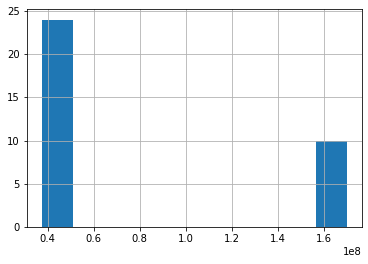

In [35]:
df_pc[f'access_size ({my_unit})'].hist()

In [36]:
def graph_by_table_with_top_x(G, df, metric_name, edges_to_collect="both", count=10, ascending=False):
    new_G = nx.DiGraph()
    t = df.sort_values(by=[metric_name], ascending=ascending)
    cnt = 0
    for idx, row in t.iterrows():
        if(len(row[0]) > 1 and isinstance(row[0], tuple)):
            iedge, oedge = row[0][0], row[0][1]
            ival = G.edges[iedge]['value']
            new_G.add_edges_from([iedge], value=ival)
            oval = G.edges[oedge]['value']
            new_G.add_edges_from([oedge], value=oval)
        else:
            node_name = row[0]
            if edges_to_collect == "in" or edges_to_collect == "both":
                for edge in G.in_edges(node_name):
                    val = G.edges[edge]['value']
                    new_G.add_edges_from([edge], value=val)
            if edges_to_collect == "out" or edges_to_collect == "both":
                for edge in G.out_edges(node_name):
                    val = G.edges[edge]['value']
                    new_G.add_edges_from([edge], value=val)                
        cnt += 1
        if cnt >= count:
            break
    return new_G

In [37]:
df_pc.sort_values(by=f'access_size ({my_unit})', ascending=False)[0:3]

,"task (p) - file, file - task (c) edges",access_size (byte)
11,"((run_openmm_py (ID0000005), stage0000_task0004.h5), (stage0000_task0004.h5, train_py (ID0000014)))",169966850.0
8,"((run_openmm_py (ID0000004), stage0000_task0003.h5), (stage0000_task0003.h5, train_py (ID0000014)))",169899942.0
5,"((run_openmm_py (ID0000003), stage0000_task0002.h5), (stage0000_task0002.h5, train_py (ID0000014)))",169768586.0


In [38]:
num_rows_to_select = 5
pc_G = graph_by_table_with_top_x(G, df_pc, f'access_size ({my_unit})', count=num_rows_to_select, ascending=False)

color_map_pc = {"task": "red",
                 "file": "blue",
                 "none": "grey",
             "producer": "green",
             "consumer": "orange"
                }

n_exp_pc, node_ref_exp_pc = get_nodes_for_sankey(pc_G, color_map_pc)
l_exp_pc = get_links_for_sankey(pc_G, node_ref_exp_pc)

fig = go.Figure(go.Sankey(
            node = n_exp_pc,
            link = l_exp_pc, orientation='h'))
printmd(f"**<center>Top ranked Producer Task-(file)-Consumer Task ({num_rows_to_select} out of {len(df_pc)})**")
fig.show()
print("\033[92mgreen: producer task")
print("\033[94mblue: file")
print("\033[93morange: consumer task")

**<center>Top ranked Producer Task-(file)-Consumer Task (5 out of 34)**

green: producer task
blue: file
orange: consumer task


In [39]:
num_rows_to_select = 10
G_file = graph_by_table_with_top_x(G, df_file, f'access_size ({my_unit})', edges_to_collect="out", count=num_rows_to_select)
n_exp_file, node_ref_exp_file = get_nodes_for_sankey(G_file)
l_exp_file = get_links_for_sankey(G_file, node_ref_exp_file)
fig = go.Figure(go.Sankey(
            node = n_exp_file,
            link = l_exp_file, orientation='h'))


printmd(f"**<center>Top ranked Files ({num_rows_to_select} out of {len(df_file)})**")
fig.show()

print("\033[94mblue: input file")
print("\033[91mred: task node")
print("\033[97mgrey: read file i/o")

**<center>Top ranked Files (10 out of 23)**

blue: input file
red: task node
grey: read file i/o


In [40]:
num_rows_to_select=3

G_task = graph_by_table_with_top_x(G, df_task, f'access_size ({my_unit})', edges_to_collect="in", count=num_rows_to_select)
n_exp_task, node_ref_exp_task = get_nodes_for_sankey(G_task)
l_exp_task = get_links_for_sankey(G_task, node_ref_exp_task)
fig = go.Figure(go.Sankey(
            node = n_exp_task,
            link = l_exp_task, orientation='h'))

printmd(f"**<center>Top ranked Tasks ({num_rows_to_select} out of {len(df_task)})**")
fig.show()

print("\033[94mblue: input file")
print("\033[91mred: task node")
print("\033[97mgrey: read file i/o")

**<center>Top ranked Tasks (3 out of 15)**

blue: input file
red: task node
grey: read file i/o


In [41]:
df_task.sort_values(by=f'access_size ({my_unit})', ascending=False)[0:3]

,node (task),access_size (byte)
13,train_py (ID0000014),1.696118e+09
12,aggregate_py (ID0000013),5.430556e+08
14,lof_py (ID0000015),4.505541e+08
